In [2]:
%matplotlib inline

import numpy as np
import scipy
from scipy import optimize
from scipy import interpolate
import matplotlib as mpl
from matplotlib import pyplot as plt
import math
from scipy.interpolate import interp1d
import warnings
warnings.simplefilter('always', DeprecationWarning)
warnings.filterwarnings('ignore')

In [3]:
# load text file MC error
file_dir = '/Users/sellberg/Documents/RESEARCH/experiments/local/BioX/ice_nucleation/results/ice_fraction/'
data_dir = '/Users/sellberg/Documents/RESEARCH/experiments/local/BioX/ice_nucleation/source/Finding_droplets/altogether/'
data = np.loadtxt(file_dir + 'MC_error/Nov_3_interpolatedpos.txt')
Temperature = data[:,4]
J = data[:,-3]
T_low =data[:,5]
T_high = data[:,6]
J_low = data[:,-2]
J_high = data[:,-1]

In [4]:
# sort temperature values
T = sorted(Temperature)

In [5]:
# sorting values based on temperature values
sort_J = [x for _,x in sorted(zip(Temperature,J))]
sort_T_low = [x for _,x in sorted(zip(Temperature,T_low))]
sort_T_high = [x for _,x in sorted(zip(Temperature,T_high))]
sort_J_low = [x for _,x in sorted(zip(Temperature,J_low))]
sort_J_high = [x for _,x in sorted(zip(Temperature,J_high))]

In [6]:
# linear fit y= mx+b, y_intercept b = y - mx
def slope_and_intercept(xs,ys):
    m = ((np.mean(xs) * np.mean(ys)) - np.mean(xs * ys))/ ((np.mean(xs) * np.mean(xs)) - np.mean(xs * xs))
    b = np.mean(ys) - (m * np.mean(xs))
    return m,b

In [7]:
# ref. The apparent activation energy and pre-exponential kinetic factor for heterogeneous calcium carbonate nucleation on quartz
# Laksmono supplementary
T_inverse = 1./np.array(T)

In [8]:
# remove the nan and inf values from T and log_J
idx = np.where((np.isnan(np.log(sort_J))==False) & (np.isinf(np.log(sort_J))==False))
new_J = np.log(sort_J)[idx]
new_T = T_inverse[idx]

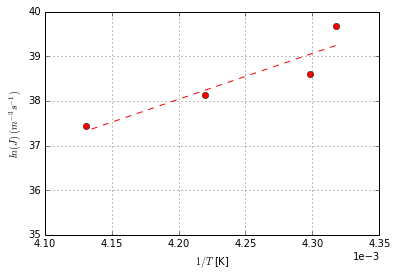

In [9]:

fig = plt.figure()
m,b = slope_and_intercept(new_T, new_J)
line_fit = np.array([(m*x)+b for x in new_T])
plt.plot(new_T, new_J, 'ro')
plt.plot(new_T, line_fit, 'r--')
plt.xlabel('$1/T$ [K]')
plt.ylabel('$ln(J)\ (m^{-3}s^{-1})$')
#plt.legend(loc='upper right',fontsize=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(35,40)
plt.axhline(0,c='black',lw=1)
plt.grid(linestyle='dotted')
plt.show()

In [11]:
J_0 = np.exp(b)
den_t = np.array(T)[idx]
J_0

0.0060042519537957225

In [12]:
#Temperature dependent densities 

data = np.loadtxt(file_dir + 'specific_volume.dat')
T_data = []
rho_data = []
for i in range(len(data)):
    rho_data.append(data[i][1])
    T_data.append(data[i][0])
T_arr = np.array(T_data)
rho_arr = np.array(rho_data)
f_rho = interp1d(T_arr, rho_arr)

# density extrapolation from Kell et al
N_A = 6.0221367e23 # molecules/mol
m_h2o = 2*1.00794+15.9995 # g/mol
# ALGORITHM 1 -- interpolation of experimental density data of ice (Ih = 0.934 g/cm^3) and water taken from Kell, Journal of Chemical Engineering Data 20, 97 (1975)
rho_si = (933.942 + 66.7829 / (1.0 + np.exp( - 0.10662 * (den_t - 233.0573)))) / 1000 # g/cm^3
rho = rho_si*N_A/1e24/m_h2o # molecules/A^3

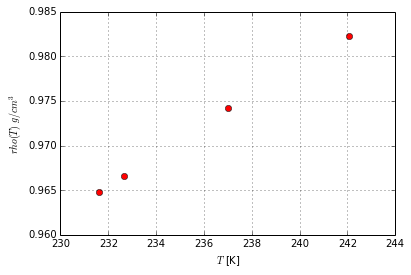

In [13]:
fig = plt.figure()
plt.plot(den_t, rho_si, 'ro')
#plt.plot(T_arr+273, rho_arr)
plt.xlabel('$T$ [K]')
plt.ylabel('$rho(T)\ g/cm^3$')
#plt.axhline(0,c='black',lw=1)
#plt.ylim(0.9,1.)
plt.grid(linestyle='dotted')
plt.show()

In [14]:
# Ice molar volume
molar_mass = 18.01528 #g/mol
ice_vol = molar_mass/rho_si #cm^3/mol
# convert to m^3/mol
#ice_vol = ice_vol*10**-6
ice_vol = (10**-30)*N_A/rho # m^3/mol

In [134]:
# make fit for D_s from SwissFEL to lab T 
D_data = np.loadtxt(file_dir + 'entropy_data_7.2.csv', delimiter=',')


T_s = np.array([D_data[i,0] for i in range(len(D_data))])
D_s = np.array([D_data[i,13] for i in range(len(D_data))])
Inv_T = 1./T_s
fit_D = interpolate.InterpolatedUnivariateSpline(Inv_T, D_s)
D = fit_D(new_T)
# Boltzmann constant : 1.380649 × 10−23 joule per kelvin
K = 1.380649e-23 # joule per kelvin

In [79]:
# experimental fit to D_s and sigma from Laksmono et al
T_arr = np.arange(235,242,0.01)
D_laksmono = 1.67e-8*np.exp(5.698332e-2*T_arr*T_arr - 2.728998e1*T_arr + 3.271878e3) # m^2/s, WRONG? off by e-5
D_VFT = 4.14e-8*np.exp(-347./(T_arr-177.))
sigma_laksmono_VFT = 1.198100169422e-11*T_arr**6 - 1.644226732545e-8*T_arr**5 + 9.387801708449e-6*T_arr**4 - 2.854359440278e-3*T_arr*T_arr*T_arr + 4.874466166395e-1*T_arr*T_arr - 4.433154987346e1*T_arr + 1.677613823216e3 # J/m^2
sigma_laksmono_PL = -6.238115076579e-10*T_arr**6 + 8.736769546436e-7*T_arr**5 - 5.098181318142e-4*T_arr**4 + 1.586558905910e-1*T_arr*T_arr*T_arr - 2.777134850571e1*T_arr*T_arr + 2.592466463405e3*T_arr - 1.008309560689e5 # J/m^2

In [80]:
D_VFT

array([  1.04404997e-10,   1.04512729e-10,   1.04620535e-10,
         1.04728414e-10,   1.04836368e-10,   1.04944396e-10,
         1.05052498e-10,   1.05160674e-10,   1.05268924e-10,
         1.05377248e-10,   1.05485646e-10,   1.05594118e-10,
         1.05702665e-10,   1.05811285e-10,   1.05919980e-10,
         1.06028749e-10,   1.06137593e-10,   1.06246510e-10,
         1.06355502e-10,   1.06464568e-10,   1.06573709e-10,
         1.06682924e-10,   1.06792213e-10,   1.06901576e-10,
         1.07011014e-10,   1.07120526e-10,   1.07230113e-10,
         1.07339774e-10,   1.07449510e-10,   1.07559320e-10,
         1.07669204e-10,   1.07779163e-10,   1.07889197e-10,
         1.07999305e-10,   1.08109488e-10,   1.08219745e-10,
         1.08330077e-10,   1.08440484e-10,   1.08550965e-10,
         1.08661521e-10,   1.08772151e-10,   1.08882856e-10,
         1.08993636e-10,   1.09104491e-10,   1.09215420e-10,
         1.09326425e-10,   1.09437503e-10,   1.09548657e-10,
         1.09659886e-10,

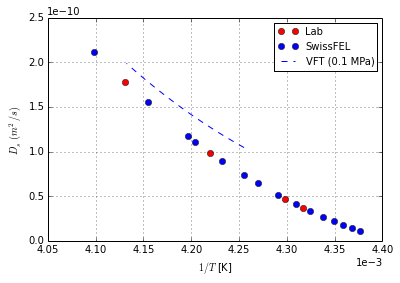

In [81]:
fig = plt.figure()
plt.plot(new_T, D, 'ro', label = 'Lab')
plt.plot(Inv_T, D_s, 'bo', label = 'SwissFEL')
#plt.plot(1/T_arr, D_laksmono, 'g--', label = 'Laksmono')
plt.plot(1/T_arr, D_VFT, 'b--', label = 'VFT (0.1 MPa)')
plt.xlabel('$1/T$ [K]')
plt.ylabel('$D_s\ (m^2/s)$')
plt.axhline(0,c='black',lw=1)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc='upper right',fontsize=10)
plt.grid(linestyle='dotted')
plt.show()

In [22]:
sigma = K*den_t*((J_0/16.)*((4./(3.*np.pi))**(1./3.))*((ice_vol)**(4./3.))/D)**2 # Joule/m^2

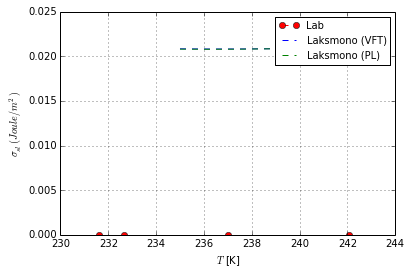

In [65]:
fig = plt.figure()
plt.plot(den_t, sigma, 'ro--', label = 'Lab')
plt.plot(T_arr, sigma_laksmono_VFT, 'b--', label = 'Laksmono (VFT)')
plt.plot(T_arr, sigma_laksmono_PL, 'g--', label = 'Laksmono (PL)')
plt.xlabel('$T$ [K]')
plt.ylabel('$\sigma_{sl}\ (Joule/m^2)$')
plt.axhline(0,c='black',lw=1)
plt.legend(loc='upper right',fontsize=10)
plt.grid(linestyle='dotted')
plt.show()

In [24]:
laksmono_T = np.array([252.23,237.36,232.03,228.81,227.58,226.57])
laksmono_T = np.array(sorted(laksmono_T))
sig_lak = (20.8*(laksmono_T/235.8)**0.67)/1000
sig_lab = (20.8*(den_t/235.8)**0.67)/1000

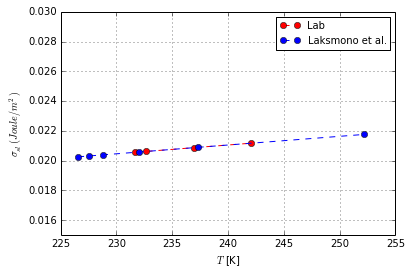

In [25]:
fig = plt.figure()
plt.plot(den_t, sig_lab, 'ro--', label = 'Lab')
plt.plot(laksmono_T, sig_lak, 'bo--', label = 'Laksmono et al.')
plt.xlabel('$T$ [K]')
plt.ylabel('$\sigma_{sl}\ (Joule/m^2)$')
plt.axhline(0,c='black',lw=1)
plt.legend(loc='upper right',fontsize=10)
plt.grid(linestyle='dotted')
plt.ylim(0.015, 0.03)
plt.show()

In [26]:
# saturation vapor pressure - water
T = den_t
#T = 273.15+38 --> 6632 Pa (water pressure)
psat_water = np.exp(54.842763 - 6763.22/T - 4.210*np.log(T) + 0.000367*T + np.tanh(0.0415*(T-218.8))*(53.878-1331.22/T- 9.44523*np.log(T) + 0.014025*T)) # Pa

# saturation vapor pressure - hexagonal ice
psat_ice = np.exp(9.550426 - 5723.265/T + 3.53068*np.log(T) - 0.00728332*T) # Pa

S = psat_water/psat_ice

In [46]:
S

array([ 1.49275026,  1.47897669,  1.42092824,  1.35413859])

In [27]:
new_J = np.log(sort_J)[idx]
new_T = T_inverse[idx]
x_coeff = new_T*new_T*new_T/np.log(S)/np.log(S)

fig = plt.figure()
m,b = slope_and_intercept(x_coeff, new_J)
line_fit = np.array([(m*x)+b for x in x_coeff])
plt.plot(x_coeff, new_J, 'ro')
plt.plot(x_coeff, line_fit, 'r--')
plt.xlabel('$1/T^3/ln(S)^2$ [K$^{-3}$]')
plt.ylabel('$ln(J)\ (m^{-3}s^{-1})$')
#plt.legend(loc='upper right',fontsize=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(37,40)
plt.xlim(4.5e-7,8e-7)
plt.axhline(0,c='black',lw=1)
plt.grid(linestyle='dotted')
plt.show()

In [28]:
#rho_ice = 0.917 # g/cm3, from wikipedia
rho_ice = 0.934 # g/cm3, from evapcool
#ice_vol_new = m_h2o/rho_ice*1e-6 # m^3/mol
ice_vol_new = m_h2o/rho_ice*1e-6/N_A # m^3/molecule

In [30]:
ice_vol/N_A, ice_vol_new

(array([  3.10067751e-29,   3.09481149e-29,   3.07059315e-29,
          3.04563995e-29]), 3.2029188938137e-29)

In [140]:
m,b = slope_and_intercept(x_coeff, new_J)
sigma_lab = np.cbrt(-m*3*K*K*K/(16*np.pi*ice_vol_new*ice_vol_new))
sigma_lab

0.010201592827459836

In [7]:
# constants
N_A = 6.0221367e23 # molecules/mol
m_h2o = 2*1.00794+15.9995 # g/mol
kB = 1.380649e-23 # J/K

# thermodynamic functions from Kell, Journal of Chemical Engineering Data 20, 97 (1975)
# ----
# density
rho_h2o_si = lambda den_t : (933.942 + 66.7829 / (1.0 + np.exp( - 0.10662 * (den_t - 233.0573)))) / 1000 # g/cm^3
rho_h2o = lambda T : rho_h2o_si(T)*N_A/1e24/m_h2o # molecule/A^3
vol_h2o = lambda T : 1e-30/rho_h2o(T) # m^3/molecule

# thermodynamic functions from Laksmono et al. JPCL (2014)
# ----
# density
rho_ice_si = lambda T : (-1.3103e-9*T*T*T + 3.8109e-7*T*T - 9.259e-5*T + 0.94040) # g/cm^3
rho_ice = lambda T : rho_ice_si(T)*N_A/1e24/m_h2o # molecule/A^3
vol_ice = lambda T : 1e-30/rho_ice(T) # m^3/molecule
#rho_ice = 0.917 # g/cm3, from wikipedia
#rho_ice = 0.934 # g/cm3, from evapcool

# droplet radius
R_droplet = 20e-6/10 # m

# saturation vapor pressure
psat_water = lambda T : np.exp(54.842763 - 6763.22/T - 4.210*np.log(T) + 0.000367*T + np.tanh(0.0415*(T-218.8))*(53.878-1331.22/T- 9.44523*np.log(T) + 0.014025*T)) # Pa
psat_hexice = lambda T : np.exp(9.550426 - 5723.265/T + 3.53068*np.log(T) - 0.00728332*T) # Pa
psat_ice = lambda T : psat_hexice(T)*np.exp(155/(N_A*kB*T))
S = lambda T : psat_water(T)/psat_ice(T)

# diffusivity
D_laksmono = lambda T_arr : 1.67e-8*np.exp(5.698332e-2*T_arr*T_arr - 2.728998e1*T_arr + 3.271878e3) # m^2/s, WRONG? off by e-5
D_VFT = lambda T_arr : 4.14e-8*np.exp(-347./(T_arr-177.)) # m^2/s
D_PL = lambda T_arr : 1.67e-8*(T_arr/223. - 1.)**1.82 # m^2/s

# interfacial free energy (surface tension)
sigma_vapor = lambda T : (111.63 - 0.13167*T)/1000 # J/m^2
sigma_MH = lambda T : (20.8*(T/235.8)**0.3)/1000 # J/m^2
sigma_laksmono_VFT = lambda T_arr : 1.198100169422e-11*T_arr**6 - 1.644226732545e-8*T_arr**5 + 9.387801708449e-6*T_arr**4 - 2.854359440278e-3*T_arr*T_arr*T_arr + 4.874466166395e-1*T_arr*T_arr - 4.433154987346e1*T_arr + 1.677613823216e3 # J/m^2
sigma_laksmono_PL = lambda T_arr : -6.238115076579e-10*T_arr**6 + 8.736769546436e-7*T_arr**5 - 5.098181318142e-4*T_arr**4 + 1.586558905910e-1*T_arr*T_arr*T_arr - 2.777134850571e1*T_arr*T_arr + 2.592466463405e3*T_arr - 1.008309560689e5 # J/m^2
#sigma_fit_pol = lambda T_arr, a, b, c, d, e, f, g : a*T_arr**6 + b*T_arr**5 + c*T_arr**4 + d*T_arr*T_arr*T_arr + e*T_arr*T_arr + f*T_arr + g
#sigma_fit_lin = lambda T_arr, k, m : k*T_arr + m
# use np.polyfit, np.polyval

# chemical potential difference
deltamu_0 = lambda T : -kB*T*np.log(S(T))
#deltamu_P = lambda T : 0
deltamu_P = lambda T : (psat_water(T) + 2*sigma_vapor(T)/R_droplet - psat_ice(T))*vol_ice(T) - (2*sigma_vapor(T)/R_droplet)*vol_h2o(T) # chemical potential from Laplace pressure
deltamu = lambda T : deltamu_0(T) + deltamu_P(T)

# free energy barriers
deltaF = lambda T, sigma : 16*np.pi*sigma*sigma*sigma*vol_ice(T)*vol_ice(T)/(3*deltamu(T)*deltamu(T)) # J/molecule
deltaf = lambda T, D : -kB*np.gradient(np.log(D), 1/T) # J/molecule

# nucleation rate
J_0 = lambda T, D, sigma : (16*np.cbrt(3*np.pi/4)*np.sqrt(sigma/kB/T)*D/np.cbrt(vol_ice(T))**4)
J = lambda T, D, sigma : J_0(T, D, sigma)*np.exp(-deltaF(T, sigma)/kB/T)

In [8]:
np.array([235, 236, 237]), D_VFT(np.array([235, 236, 237])), sigma_laksmono_VFT(np.array([235, 236, 237])), deltaF(np.array([235, 236, 237]), sigma_laksmono_VFT(np.array([235, 236, 237])))/kB/np.array([235., 236., 237.]), deltaf(np.array([235, 236, 237]), D_VFT(np.array([235, 236, 237]))), J(np.array([235, 236, 237]), D_VFT(np.array([235, 236, 237])), sigma_laksmono_VFT(np.array([235, 236, 237])))

(array([235, 236, 237]),
 array([  1.04404997e-10,   1.15547330e-10,   1.27447285e-10]),
 array([ 0.02084975,  0.02083078,  0.02082868]),
 array([ 55.3567956 ,  58.04136811,  61.16298405]),
 array([-inf, -inf, -inf]),
 array([  4.95771294e+14,   3.73441818e+13,   1.81163189e+12]))

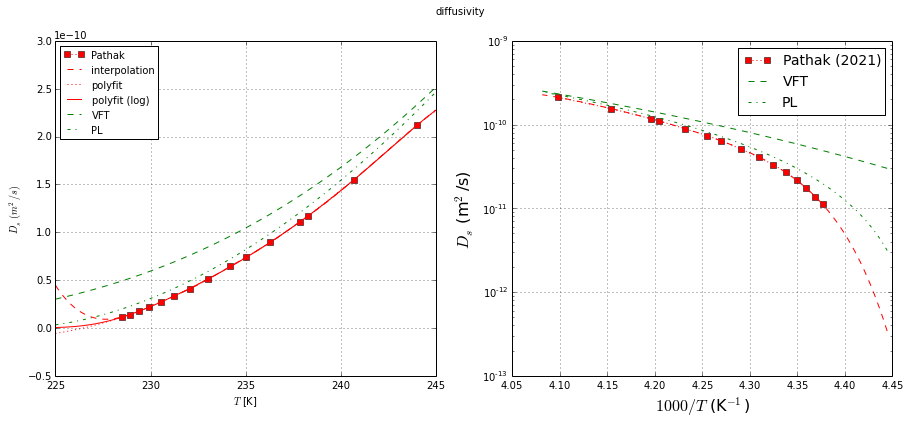

In [9]:
# experimental diffusivity data from SwissFEL
data_SwissFEL = np.loadtxt(file_dir + 'entropy_data_7.2.csv', delimiter=',')
T_SwissFEL = np.array([data_SwissFEL[i,0] for i in range(len(data_SwissFEL))])
D_SwissFEL = np.array([data_SwissFEL[i,13] for i in range(len(data_SwissFEL))])
D_SwissFEL_invT = interpolate.InterpolatedUnivariateSpline(1/T_SwissFEL, D_SwissFEL)
p_SwissFEL = np.polyfit(T_SwissFEL, D_SwissFEL, 6, rcond=None, full=False, w=None, cov=False)
p_SwissFEL_invT_log = np.polyfit(1/T_SwissFEL, np.log(D_SwissFEL), 6, rcond=None, full=False, w=None, cov=False)
D_SwissFEL_fit = lambda T: np.polyval(p_SwissFEL, T)
D_SwissFEL_fit_log = lambda T: np.exp(np.polyval(p_SwissFEL_invT_log, 1/T))

# plot data
#T_arr = np.arange(np.ceil(T_SwissFEL.min()), np.floor(T_SwissFEL.max()), 0.01)
T_arr = np.arange(225,245,0.01)

f, axes = plt.subplots(nrows=1, ncols=2,  figsize=(15, 6))
f.suptitle('diffusivity')

axes[0].plot(T_SwissFEL, D_SwissFEL, 'rs:', label='Pathak')
axes[0].plot(T_arr, D_SwissFEL_invT(1/T_arr), 'r--', label='interpolation')
axes[0].plot(T_arr, D_SwissFEL_fit(T_arr), 'r:', label='polyfit')
axes[0].plot(T_arr, D_SwissFEL_fit_log(T_arr), 'r-', label='polyfit (log)')
axes[0].plot(T_arr, D_VFT(T_arr), 'g--', label='VFT')
axes[0].plot(T_arr, D_PL(T_arr), 'g-.', label='PL')
#axes[0].plot(T_arr, D_laksmono(T_arr), 'b--', label='Laksmono (CNT fit)')
axes[0].set_xlabel('$T$ [K]')
axes[0].set_ylabel('$D_s\ (m^2/s)$')
#axes[0].set_xlim(200,250)
#axes[0].set_ylim(0.274,0.279)
axes[0].legend(loc='upper left', prop={'size': 10})
axes[0].grid(linestyle='dotted')

axes[1].semilogy(1000/T_SwissFEL, D_SwissFEL, 'rs:', label='Pathak (2021)')
#axes[1].semilogy(1000/T_arr, D_SwissFEL_invT(1/T_arr), 'r--', label='interpolation')
#axes[1].semilogy(1000/T_arr, D_SwissFEL_fit(T_arr), 'r:', label='polyfit')
#axes[1].semilogy(1000/T_arr, D_SwissFEL_fit_log(T_arr), 'r-', label='polyfit (log)')
axes[1].semilogy(1000/T_arr, D_SwissFEL_fit_log(T_arr), 'r--',)
axes[1].semilogy(1000/T_arr, D_VFT(T_arr), 'g--', label='VFT')
axes[1].semilogy(1000/T_arr, D_PL(T_arr), 'g-.', label='PL')
#axes[1].semilogy(1000/T_arr, D_laksmono(T_arr), 'b--', label='Laksmono (CNT fit)')
axes[1].legend(loc='upper right', prop={'size': 14})
axes[1].set_xlabel('$1000/T$ (K$^{-1}$)', fontsize=16)
axes[1].set_ylabel('$D_s$ (m$^2$/s)', fontsize=16)
#axes[1].set_title('diffusivity')
#axes[1].set_xlim(170,310)
#axes[1].set_ylim(0.274,0.279)
axes[1].grid(linestyle='dotted')

plt.savefig('fig1-diffusivity.eps', format='eps')
plt.show()

In [10]:
# data from lab experiments (Mar-Dec 2020)
file_dir = '/Users/sellberg/Documents/RESEARCH/experiments/local/BioX/ice_nucleation/results/ice_fraction/'

# Mar 12 2020
time1 = np.array([1.068999028, 1.554907677, 1.943634597, 2.429543246, 2.915451895, 3.401360544, 3.644314869, 3.887269193, 4.130223518, 4.373177843, 4.616132167, 4.859086492]) # ms
T1 = np.array([(246.0582851+241.4707365)/2,241.4707365,238.9234228,236.5170494,234.6541388,233.1494294,232.4962372,231.8962764,231.3422528,230.8282207,230.3492746,(230.3492746+229.9013269)/2]) # K
# counts
ntot1 = np.array([357, 183, 105, 158, 113, 471, 319, 406, 327, 454, 206, 220])
nmarbles1 = np.array([0, 0, 0, 0, 1, 9, 4, 4, 3, 36, 70, 39])
nblobs1 = np.array([0, 0, 0, 0, 1, 16, 23, 19, 17, 34, 50, 140])
nfract1 = np.array([0, 0, 0, 0, 0, 0, 0, 3, 1, 5, 6, 16])
ndist1 =  np.array([0, 0, 0, 0, 0, 2, 3, 2, 3, 2, 2, 7])
# fractions
fice1 = (nmarbles1 + nblobs1 + nfract1 + ndist1)/ntot1.astype(np.float)
fmarbles1 = nmarbles1/ntot1.astype(np.float)
fblobs1 = nblobs1/ntot1.astype(np.float)
ffract1 = nfract1/ntot1.astype(np.float)
fdist1 = ndist1/ntot1.astype(np.float)
# nucleation rate
V1 = 5.24E-18 # m^3*s/ms
J1 = -np.gradient(np.log(1-fice1), time1)/V1 # /m^3/s
# load text file MC error
data = np.loadtxt(file_dir + 'MC_error/Mar_12_interpolatedpos.txt')
T1_MC = data[:,4]
J1_MC = data[:,-3]
T1_MC_low = data[:,5]
T1_MC_high = data[:,6]
J1_MC_low = data[:,-2]
J1_MC_high = data[:,-1]


# Nov 3 2020
time2 = np.array([1.140684411,1.520912548,1.901140684,2.281368821,2.661596958,3.041825095,3.422053232,3.802281369]) # ms
T2 = np.array([(241.6097934+238.3524206)/2,238.3524206,235.9850406,234.1522187,232.6715239,231.4380465,230.3864514,(230.3864514+229.4735652)/2]) # K
# counts
ntot2 = np.array([48,39,34,210,715,881,797,292])
nmarbles2 = np.array([0,1,0,5,12,13,31,21])
nblobs2 = np.array([0,0,0,6,12,14,62,22])
nfract2 = np.array([0,0,0,0,0,2,0,0])
ndist2 = np.array([0,0,0,2,3,6,13,6])
# fractions
fice2 = (nmarbles2 + nblobs2 + nfract2 + ndist2)/ntot2.astype(np.float)
fmarbles2 = nmarbles2/ntot2.astype(np.float)
fblobs2 = nblobs2/ntot2.astype(np.float)
ffract2 = nfract2/ntot2.astype(np.float)
fdist2 = ndist2/ntot2.astype(np.float)
# nucleation rate
V2 = 4.551E-18 # m^3*s/ms
J2 = -np.gradient(np.log(1-fice2), time2)/V2 # /m^3/s
# load text file MC error
data = np.loadtxt(file_dir + 'MC_error/Nov_3_interpolatedpos.txt')
T2_MC = data[:,4]
J2_MC = data[:,-3]
T2_MC_low = data[:,5]
T2_MC_high = data[:,6]
J2_MC_low = data[:,-2]
J2_MC_high = data[:,-1]


# Dec 7 2020
time3 = np.array([3.373060174, 3.794692695, 4.005508956, 4.216325217])
T3 = np.array([231.5241886, 230.4749207, 230.0041271, 229.5636484])
# counts
ntot3 = np.array([633, 566, 298, 325])
nmarbles3 = np.array([12, 149, 74, 15])
nblobs3 = np.array([15, 50, 192, 176])
nfractdist3 = np.array([2, 6, 28, 134])
#nwater3 = np.array([604, 361, 4, 0]) # ntot3 - nblobs3 - nmarbles3 - nfractdist3
# fractions
fice3 = (nmarbles3 + nblobs3 + nfractdist3)/ntot3.astype(np.float)
fmarbles3 = nmarbles3/ntot3.astype(np.float)
fblobs3 = nblobs3/ntot3.astype(np.float)
ffractdist3 = nfractdist3/ntot3.astype(np.float)
# numerical correction to 100% ice
fice3[np.where(fice3 >= 1)] = 0.999
#fice3[np.where(fice3 >= 1)] = 0.999999
# nucleation rate
V3 = 3.13E-18 # m^3*s/ms
J3 = -np.gradient(np.log(1-fice3), time3)/V3 # /m^3/s
# load text file MC error
data = np.loadtxt(file_dir + 'MC_error/Dec_7_interpolatedpos.txt')
T3_MC = data[:,4]
J3_MC = data[:,-3]
T3_MC_low = data[:,5]
T3_MC_high = data[:,6]
J3_MC_low = data[:,-2]
J3_MC_high = data[:,-1]


# Laksmono JPCL (2014)
T_laksmono = np.array([230.42,228.19,227.08,231.79,229.16])
J_laksmono = np.array([2.11E+11,3.22E+12,3.58E+12,2.69E+11,8.45E+11])*1e6 # /m^3/s
T_laksmono_low = np.array([1.00, 1.00, 1.00, 1.00, 1.00])
T_laksmono_high = np.array([2.00, 2.00, 2.00, 2.00, 2.00])
J_laksmono_low = np.array([1.38E+11, 7.90E+11, 2.79E+12, 3.90E+10, 3.71E+11])*1E+6
J_laksmono_high = np.array([3.12E+12, 4.60E+13, 5.76E+13, 3.81E+12, 1.22E+13])*1E+6


In [11]:
# load Murray 2010 data Run1
data = np.loadtxt(data_dir + 'Murray_dataset/Ben1.txt')
T_Ben1 = data[:,0]
J_Ben1 = data[:,1]*10**6
J_up_Ben1 =data[:,2]*10**6
J_down_Ben1 = data[:,3]*10**6

# load Murray 2010 data Run2
data = np.loadtxt(data_dir + 'Murray_dataset/Ben2.txt')
T_Ben2 = data[:,0]
J_Ben2 = data[:,1]*10**6
J_up_Ben2 =data[:,2]*10**6
J_down_Ben2 = data[:,3]*10**6

# load Murray 2021 (latest publication)
Run1 = np.loadtxt(data_dir + 'Murray_dataset/Murray_Run1.txt')
Run2 = np.loadtxt(data_dir + 'Murray_dataset/Murray_Run2.txt')
Run3 = np.loadtxt(data_dir + 'Murray_dataset/Murray_Run3.txt')

# Run 1
T_Murray_R1 = Run1[:,0] + 273.
T_R1_err = Run1[:,1]
J_Murray_R1 = Run1[:,2]*10**6
J_R1_up = Run1[:,3]*10**6
J_R1_down = Run1[:,4]*10**6

# Run 2
T_Murray_R2 = Run2[:,0] + 273.
T_R2_err = Run2[:,1]
J_Murray_R2 = Run2[:,2]*10**6
J_R2_up = Run2[:,3]*10**6
J_R2_down = Run2[:,4]*10**6

# Run 3
T_Murray_R3 = Run3[:,0] + 273.
T_R3_err = Run3[:,1]
J_Murray_R3 = Run3[:,2]*10**6
J_R3_up = Run3[:,3]*10**6
J_R3_down = Run3[:,4]*10**6

In [17]:
# fit interfacial free energy to nucleation rate data
sigma_errfunc = lambda p, T, data: (np.hstack(data) - J(np.hstack(T), D_SwissFEL_fit_log(np.hstack(T)), np.polyval(p, np.hstack(T)))).flatten()
sigma_errfunc_log = lambda p, T, data: np.log10(np.abs((np.hstack(data) - J(np.hstack(T), D_SwissFEL_fit_log(np.hstack(T)), np.polyval(p, np.hstack(T)))).flatten()))
#sigma_errfunc_log = lambda p, T, data: np.log10(np.abs((np.hstack(data) - J(np.hstack(T), D_SwissFEL_fit_log(np.hstack(T)), np.polyval(p, np.hstack(T)))).flatten()))

# interfacial free energy - polynomial (6 degree) - lab data
p0 = [1.198100169422e-11, -1.644226732545e-8, 9.387801708449e-6, -2.854359440278e-3, +4.874466166395e-1, -4.433154987346e1, +1.677613823216e3]
[p1, success] = optimize.leastsq(sigma_errfunc_log, p0[:], args=([T1[np.where(J1 > 1e15)], T2[np.where(J2 > 1e15)], T3[np.where(J3 > 1e15)]], [J1[np.where(J1 > 1e15)], J2[np.where(J2 > 1e15)], J3[np.where(J3 > 1e15)]]))

if success:
    print 'Lab data (Mar-Dec 2020) - polynomial fit'
    print p1
    print sigma_errfunc_log(p1, T1[np.where(J1 > 1e15)], J1[np.where(J1 > 1e15)])
    print np.polyval(p1, T1)#, sigma_laksmono_VFT(T1), T1

# interfacial free energy - polynomial (6 degree) - lab data + Murray data (2021) + Laksmono data (2014)
#p0 = [1.19e-11, -1.64e-8, 9.38e-6, -2.85e-3, +4.87e-1, -4.43e1, +1.67e3] # from Laksmono (2014)
[p2, success] = optimize.leastsq(sigma_errfunc_log, p0[:], args=([T1[np.where(J1 > 1e15)], T2[np.where(J2 > 1e15)], T3[np.where(J3 > 1e15)], T_Murray_R1, T_Murray_R2, T_Murray_R3, T_laksmono], [J1[np.where(J1 > 1e15)], J2[np.where(J2 > 1e15)], J3[np.where(J3 > 1e15)], J_Murray_R1, J_Murray_R2, J_Murray_R3, J_laksmono]), ftol=1.49012e-08, xtol=1.49012e-01, maxfev=10000)

if success:
    print 'Lab data (Mar-Dec 2020) + Murray (2021) + Laksmono (2014) - polynomial fit'
    print p2
    print sigma_errfunc_log(p2, T1[np.where(J1 > 1e15)], J1[np.where(J1 > 1e15)])
    print np.polyval(p2, T1)#, sigma_laksmono_VFT(T1), T1

# interfacial free energy - polynomial (6 degree) - lab data + Murray data (2021) + Laksmono data (2014)
p0 = [0.124/1000, 29.1/1000-273.14*0.124/1000] # from Ickes (2015)
[p3, success] = optimize.leastsq(sigma_errfunc_log, p0[:], args=(np.array([T1[np.where(J1 > 1e15)], T2[np.where(J2 > 1e15)], T3[np.where(J3 > 1e15)], T_Murray_R1, T_Murray_R2, T_Murray_R3, T_laksmono]), [J1[np.where(J1 > 1e15)], J2[np.where(J2 > 1e15)], J3[np.where(J3 > 1e15)], J_Murray_R1, J_Murray_R2, J_Murray_R3, J_laksmono]))

if success:
    print 'Lab data (Mar-Dec 2020) + Murray (2021) + Laksmono (2014) - linear fit'
    print p3
    print sigma_errfunc_log(p3, T1[np.where(J1 > 1e15)], J1[np.where(J1 > 1e15)])
    print np.polyval(p3, T1)#, sigma_laksmono_VFT(T1), T1



Lab data (Mar-Dec 2020) - polynomial fit
[  1.19809800e-11  -1.64422620e-08   9.38780217e-06  -2.85435927e-03
   4.87446663e-01  -4.43315459e+01   1.67761028e+03]
[ 15.5449076   16.06418285  16.41823872  15.68842558  16.65251371
  17.54590799  17.95911579  18.08042792]
[ 0.02535736  0.02507449  0.02480077  0.02460653  0.0245176   0.02449445
  0.02449955  0.02451282  0.0245326   0.02455758  0.0245867   0.02460228]
Lab data (Mar-Dec 2020) + Murray (2021) + Laksmono (2014) - polynomial fit
[  1.19810017e-11  -1.64422673e-08   9.38780171e-06  -2.85435944e-03
   4.87446617e-01  -4.43315499e+01   1.67761382e+03]
[ 15.544128    16.03483308  16.12324313  16.46402882  16.92682363
  17.17504661  17.7989163   17.94689464]
[ 0.02110491  0.02097172  0.02086453  0.02082771  0.02086059  0.02093575
  0.02098348  0.02103589  0.02109178  0.02115025  0.02121055  0.0212407 ]
Lab data (Mar-Dec 2020) + Murray (2021) + Laksmono (2014) - linear fit
[ 0.000123   -0.00499719]
[ 15.5449076   16.06418285  16.4182

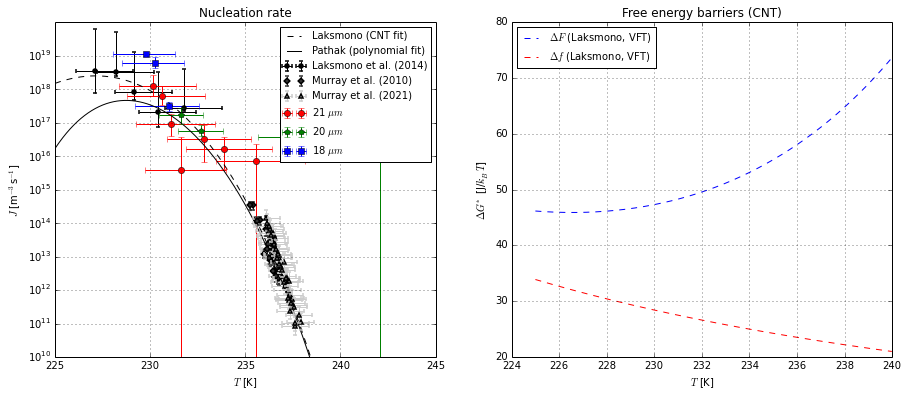

In [18]:
T_arr = np.arange(225,240,0.01)

# plot nucleation rate J and kinetic and thermodynamic free energy barrier
f, axes = plt.subplots(nrows=1, ncols=2,  figsize=(15, 6))
err_linestyle = {"linewidth":1, "markeredgewidth":1.5, "elinewidth":1, "capsize":2}

#axes[0].semilogy(T2_MC, J2_MC, 'r^:', label='Nov 2020 (MC)')
axes[0].semilogy(T_arr, J(T_arr, D_VFT(T_arr), sigma_laksmono_VFT(T_arr)), 'k--', label='Laksmono (CNT fit)')
axes[0].semilogy(T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), np.polyval(p2, T_arr)), 'k-', label='Pathak (polynomial fit)')
#axes[0].semilogy(T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), np.polyval(p3, T_arr)), 'k:', label='Pathak (linear fit)')
#axes[0].semilogy(T_arr, J(T_arr, D_SwissFEL_fit_log(T_arr), sigma_laksmono_VFT(T_arr)), 'm:', label='Pathak (CNT fit)')
#axes[0].semilogy(T_laksmono, J_laksmono, 'ko', label='Laksmono')
#axes[0].semilogy(T1, J1, 'ro:', label='Mar 2020')
#axes[0].errorbar(T1_MC[np.where(J1_MC > 0)], J1_MC[np.where(J1_MC > 0)], xerr=[T1_MC_low[np.where(J1_MC > 0)], T1_MC_high[np.where(J1_MC > 0)]], yerr=[J1_MC_low[np.where(J1_MC > 0)], J1_MC_high[np.where(J1_MC > 0)]] , label='Mar 2020 (MC)', fmt='rs')
#axes[0].semilogy(T2, J2, 'g^:', label='Nov 2020')
#axes[0].errorbar(T2_MC[np.where(J2_MC > 0)], J2_MC[np.where(J2_MC > 0)], xerr=[T2_MC_low[np.where(J2_MC > 0)], T2_MC_high[np.where(J2_MC > 0)]], yerr=[J2_MC_low[np.where(J2_MC > 0)], J2_MC_high[np.where(J2_MC > 0)]] , label='Nov 2020 (MC)', fmt='gs')
#axes[0].semilogy(T3, J3, 'bs:', label='Dec 2020')
#axes[0].errorbar(T3_MC[np.where(J3_MC > 0)], J3_MC[np.where(J3_MC > 0)], xerr=[T3_MC_low[np.where(J3_MC > 0)], T3_MC_high[np.where(J3_MC > 0)]], yerr=[J3_MC_low[np.where(J3_MC > 0)], J3_MC_high[np.where(J3_MC > 0)]] , label='Dec 2020 (MC)', fmt='bs')
axes[0].errorbar(T_laksmono, J_laksmono, xerr=[T_laksmono_low, T_laksmono_high], yerr=[J_laksmono_low, J_laksmono_high], fmt='ko', ms=4, label='Laksmono et al. (2014)', **err_linestyle)
#axes[0].errorbar(T_Ben1, J_Ben1, yerr=[J_down_Ben1, J_up_Ben1], fmt='yo', ms=4, label='Murray et al. (2010)', **err_linestyle)
#axes[0].errorbar(T_Ben2, J_Ben2, yerr=[J_down_Ben2, J_up_Ben2], fmt='yo', ms=4, **err_linestyle)
axes[0].errorbar(T_Ben1, J_Ben1, yerr=[J_down_Ben1, J_up_Ben1], fmt='D', color='0.2', ms=4, label='Murray et al. (2010)', **err_linestyle)
axes[0].errorbar(T_Ben2, J_Ben2, yerr=[J_down_Ben2, J_up_Ben2], fmt='D', color='0.2', ms=4, **err_linestyle)
#axes[0].errorbar(T_Murray_R1, J_Murray_R1, yerr=[J_R1_down, J_R1_up], xerr=[T_R1_err, T_R1_err], fmt='mo', ms=4, label='Murray et al. (2021)', **err_linestyle)
#axes[0].errorbar(T_Murray_R2, J_Murray_R2, yerr=[J_R2_down, J_R2_up], xerr=[T_R2_err, T_R2_err], fmt='mo', ms=4, **err_linestyle)
#axes[0].errorbar(T_Murray_R3, J_Murray_R3, yerr=[J_R3_down, J_R3_up], xerr=[T_R3_err, T_R3_err], fmt='mo', ms=4, **err_linestyle)
axes[0].errorbar(T_Murray_R1, J_Murray_R1, yerr=[J_R1_down, J_R1_up], xerr=[T_R1_err, T_R1_err], fmt='^', color='0.8', ms=4, label='Murray et al. (2021)', **err_linestyle)
axes[0].errorbar(T_Murray_R2, J_Murray_R2, yerr=[J_R2_down, J_R2_up], xerr=[T_R2_err, T_R2_err], fmt='^', color='0.8', ms=4, **err_linestyle)
axes[0].errorbar(T_Murray_R3, J_Murray_R3, yerr=[J_R3_down, J_R3_up], xerr=[T_R3_err, T_R3_err], fmt='^', color='0.8', ms=4, **err_linestyle)
axes[0].errorbar(T1_MC[np.where(J1_MC > 0)], J1_MC[np.where(J1_MC > 0)], xerr=[T1_MC_low[np.where(J1_MC > 0)], T1_MC_high[np.where(J1_MC > 0)]], yerr=[J1_MC_low[np.where(J1_MC > 0)], J1_MC_high[np.where(J1_MC > 0)]] , label='21 $\mu m$', fmt='ro')
axes[0].errorbar(T2_MC[np.where(J2_MC > 0)], J2_MC[np.where(J2_MC > 0)], xerr=[T2_MC_low[np.where(J2_MC > 0)], T2_MC_high[np.where(J2_MC > 0)]], yerr=[J2_MC_low[np.where(J2_MC > 0)], J2_MC_high[np.where(J2_MC > 0)]] , label='20 $\mu m$', fmt='gp')
axes[0].errorbar(T3_MC[np.where(J3_MC > 0)], J3_MC[np.where(J3_MC > 0)], xerr=[T3_MC_low[np.where(J3_MC > 0)], T3_MC_high[np.where(J3_MC > 0)]], yerr=[J3_MC_low[np.where(J3_MC > 0)], J3_MC_high[np.where(J3_MC > 0)]] , label='18 $\mu m$', fmt='bs')
axes[0].legend(loc='upper right', prop={'size': 10})
axes[0].set_xlabel('$T$ [K]')
axes[0].set_ylabel('$J$ [m$^{-3}$s$^{-1}$]')
axes[0].set_title('Nucleation rate')
#axes[0].set_xlim(170,310)
axes[0].set_ylim(1e10,1e20)
axes[0].set_yscale('symlog')
axes[0].grid(linestyle='dotted')

axes[1].plot(T_arr, deltaF(T_arr, sigma_laksmono_VFT(T_arr))/kB/T_arr, 'b--', label='$\Delta F$ (Laksmono, VFT)')
axes[1].plot(T_arr, deltaf(T_arr, D_VFT(T_arr))/kB/T_arr, 'r--', label='$\Delta f$ (Laksmono, VFT)')
#axes[1].plot(T_arr, deltaF(T_arr, np.polyval(p2, T_arr))/kB/T_arr, 'b-', label='$\Delta F$ (Pathak, CNT)')
#axes[1].plot(T_arr, deltaf(T_arr, D_SwissFEL_fit_log(T_arr))/kB/T_arr, 'r-', label='$\Delta f$ (Pathak, CNT)')
axes[1].legend(loc='upper left', prop={'size': 10})
axes[1].set_xlabel('$T$ [K]')
axes[1].set_ylabel('$\Delta G^*$ [J/$k_B T$]')
axes[1].set_title('Free energy barriers (CNT)')
axes[1].grid(linestyle='dotted')

plt.savefig('fig2-nucleation_rate.eps', format='eps')
plt.show()

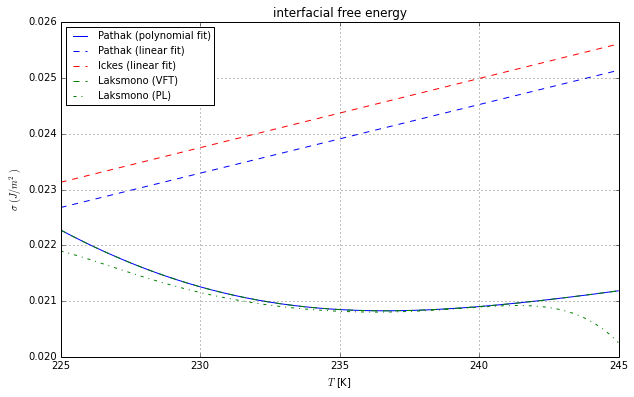

In [19]:
# plot interfacial free energy
T_arr = np.arange(225,245,0.01)

f = plt.figure(figsize=(10, 6))
plt.title('interfacial free energy')

plt.plot(T_arr, np.polyval(p2, T_arr), 'b-', label='Pathak (polynomial fit)')
plt.plot(T_arr, np.polyval(p3, T_arr), 'b--', label='Pathak (linear fit)')
#plt.plot(T_arr, np.polyval([0.124/1000, 29.1/1000], T_arr-273.14), 'r--', label='Ickes (linear fit)')
plt.plot(T_arr, np.polyval([0.124/1000, 29.1/1000-273.14*0.124/1000], T_arr), 'r--', label='Ickes (linear fit)')
plt.plot(T_arr, sigma_laksmono_VFT(T_arr), 'g--', label='Laksmono (VFT)')
plt.plot(T_arr, sigma_laksmono_PL(T_arr), 'g-.', label='Laksmono (PL)')
#axes[0].plot(T_arr, D_laksmono(T_arr), 'b--', label='Laksmono (CNT fit)')
plt.xlabel('$T$ [K]')
plt.ylabel('$\sigma\ (J/m^2)$')
#axes[0].set_xlim(200,250)
#axes[0].set_ylim(0.274,0.279)
plt.legend(loc='upper left', prop={'size': 10})
plt.grid(linestyle='dotted')

plt.savefig('fig4-interfacial_energy.eps', format='eps')
plt.show()

In [71]:
T = T1[np.where(J1 > 1e15)] - 273.14
J(np.hstack(T), D_SwissFEL_fit_log(np.hstack(T)), np.polyval(p3, np.hstack(T)))

optimize.leastsq?

In [105]:
sigma_errfunc_test = lambda p, T, data: np.log10(np.hstack(data) - J(np.hstack(T), D_SwissFEL_fit_log(np.hstack(T)), np.polyval(p, np.hstack(T))))

p0 = [1.19e-11, -1.64e-8, 9.38e-6, -2.85e-3, +4.87e-1, -4.43e1, +1.67e3] # from Laksmono (2014)
J_data = [J1[np.where(J1 > 1e15)], J2[np.where(J2 > 1e15)], J3[np.where(J3 > 1e15)], J_Murray_R1, J_Murray_R2, J_Murray_R3, J_laksmono]
T_data = [T1[np.where(J1 > 1e15)], T2[np.where(J2 > 1e15)], T3[np.where(J3 > 1e15)], T_Murray_R1, T_Murray_R2, T_Murray_R3, T_laksmono]
[p4, success] = optimize.leastsq(sigma_errfunc_test, p0[:], args=(J_data, T_data), ftol=1.49012e-08, xtol=1.49012e-01, maxfev=10000, full_output=False)
sigma_errfunc_test(p4, T_data, J_data)


array([ 15.5449076 ,  16.06418285,  16.41823872,  15.68842558,
        16.65251371,  17.54590799,  17.95911579,  18.08042792,
        16.1764126 ,  16.03978247,  16.04620863,  16.47877478,
        16.61662269,  16.37439441,  17.48463247,  18.60235153,
        18.68962223,  18.59501617,  11.05381303,  10.9134704 ,
        11.56384984,  11.75153231,  11.74026919,  12.2584704 ,
        12.36762628,  11.84505882,  12.25510384,  11.9887454 ,
        12.11340577,  12.41016227,  12.68435985,  12.7440628 ,
        13.03342376,  13.17609126,  13.26245109,  13.38738983,
        13.56229286,  13.44870632,  13.56820172,  13.61595005,
        13.75204845,  13.9127533 ,  14.13672057,  11.26259113,
        11.01884977,  11.73677554,  11.68801851,  12.26432298,
        12.84207106,  12.95465616,  13.43775056,  13.71349054,
        14.00432137,  11.49770791,  11.61549004,  11.38202594,
        11.77438677,  12.37287162,  12.25000635,  12.60265495,
        12.76368439,  12.96540252,  13.06818586,  13.23

In [ ]:
# fit nucleation rate data directly to include uncertainties


In [134]:
J(T1, D_SwissFEL_fit_log(T1), np.polyval(p1, T1)), J(T1, D_SwissFEL_fit_log(T1), sigma_laksmono_VFT(T1))
J(T1[-1], D_SwissFEL_fit_log(T1)[-1], 0.025), J1[-1]
J(T1, D_SwissFEL_fit_log(T1), np.polyval(p2, T1)), T1
np.polyval(p1, T1), sigma_laksmono_VFT(T1)

(array([ 0.02535736,  0.02507449,  0.02480077,  0.02460653,  0.0245176 ,
         0.02449445,  0.02449955,  0.02451282,  0.0245326 ,  0.02455758,
         0.0245867 ,  0.02460228]),
 array([ 0.02110491,  0.02097172,  0.02086453,  0.02082771,  0.02086059,
         0.02093575,  0.02098348,  0.02103589,  0.02109178,  0.02115025,
         0.02121055,  0.0212407 ]))

In [114]:
sigma_errfunc_log(p1, T1, J1), sigma_errfunc_log(p2, T1, J1)

(array([-35.17506539, -21.82053285, -11.16108335,  15.5449076 ,
         16.06418285,  16.41823872,  15.68842558,  15.94701114,
         16.65251371,  17.54590799,  17.95911579,  18.08042792]),
 array([ -3.77647799,   3.36729887,   9.03603962,  15.544128  ,
         16.03483308,  16.12324313,  16.46402882,  16.9089511 ,
         16.92682363,  17.17504661,  17.7989163 ,  17.94689464]))

In [126]:
J1[np.where(J1 > 1e15)], T1[np.where(J1 > 1e15)]

(array([  3.50677258e+15,   1.15926534e+16,   2.61962252e+16,
          4.88006476e+15,   4.49276507e+16,   3.51485969e+17,
          9.10155910e+17,   1.20344962e+18]),
 array([ 236.5170494 ,  234.6541388 ,  233.1494294 ,  232.4962372 ,
         231.3422528 ,  230.8282207 ,  230.3492746 ,  230.12530075]))

In [130]:
J2_MC[np.where(J2_MC > 0)], J2_MC_low[np.where(J2_MC > 0)], J2_MC_high[np.where(J2_MC > 0)]

(array([  1.79560000e+16,   3.64760000e+16,   5.80310000e+16,
          1.71850000e+17]),
 array([  1.79560000e+16,   1.70810000e+16,   1.90350000e+16,
          8.09020000e+16]),
 array([  4.38650000e+16,   2.45350000e+16,   2.42770000e+16,
          1.09030000e+17]))

In [218]:
J2_MC[np.where(J2_MC > 0)], T2_MC[np.where(J2_MC > 0)], J2_MC_low[np.where(J2_MC > 0)], J2_MC_high[np.where(J2_MC > 0)]

(array([  1.79560000e+16,   3.64760000e+16,   5.80310000e+16,
          1.71850000e+17]),
 array([ 242.06,  237.  ,  232.66,  231.63]),
 array([  1.79560000e+16,   1.70810000e+16,   1.90350000e+16,
          8.09020000e+16]),
 array([  4.38650000e+16,   2.45350000e+16,   2.42770000e+16,
          1.09030000e+17]))

In [220]:
T2_MC_low

array([ 1.4824,  1.4011,  1.3344,  1.2741,  1.224 ,  1.1838,  1.1496])

In [27]:
0.917, # g/cm3, from wikipedia
0.934, # g/cm3, from evapcool
m_h2o/vol_ice(T1)/N_A/1e6 # g/cm3

array([ 0.92149526,  0.92181423,  0.92216145,  0.92248281,  0.92272723,
        0.9229219 ,  0.92300565,  0.92308217,  0.9231525 ,  0.92321746,
        0.92327774,  0.92330584])

In [32]:
2*sigma_vapor(T1)/R_droplet, psat_water(T1)

(array([ 79533.52686296,  79835.54812504,  80170.95291992,  80487.8001055 ,
         80733.0895442 ,  80931.2146309 ,  81017.22044788,  81096.21728641,
         81169.16557382,  81236.84818043,  81299.91101342,  81329.40165025]),
 array([ 53.96820237,  43.41514311,  33.90440555,  26.69007131,
         22.09015745,  18.91102658,  17.66439666,  16.58523335,
         15.64193815,  14.81034437,  14.07166314,  13.73778452]))

In [63]:
psat_hexice(T1), psat_ice(T1)

(array([ 40.51531214,  31.87996997,  24.29786598,  18.69876776,
         15.21069277,  12.84345216,  11.92599127,  11.13707008,
         10.45169528,   9.85089286,   9.32001177,   9.08094862]),
 array([ 43.73533519,  34.43869393,  26.26965522,  20.2322412 ,
         16.46841336,  13.91256519,  12.92163554,  12.06935459,
         11.32878785,  10.67948316,  10.10564477,   9.84720532]))

In [17]:
T_arr

array([ 225.  ,  225.01,  225.02, ...,  239.97,  239.98,  239.99])

In [139]:
fice2

array([ 0.        ,  0.02564103,  0.        ,  0.06190476,  0.03776224,
        0.03972758,  0.13299875,  0.16780822])